tmp# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
Write the name (first and last) of the people on your team that are responsible for developing this solution.

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1]:
# Imports
import os
import glob
import math
import numpy as np
import pandas as pd
import pylab
import seaborn as sns

In [2]:
# Helper functions for loading data

def load_noise_data(file_paths, sensor_list):
    """
    Function for loading noise data into the correct format
    """
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, header=8, sep=';')
        df = df.melt(id_vars=['Data', 'Ora'])
        df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Ora'])
        df.columns = ['Date', 'Time', 'Sensor_ID', 'Intensity', 'Timestamp']
        df['Intensity'] = df['Intensity'].str.replace(',', '.').astype(float)

        concat_data.append(df)

    concat_df = pd.concat(concat_data)

    output = concat_df.merge(sensor_list, on=['Sensor_ID'])
    
    return output[['Timestamp', 'Sensor_ID', 'Intensity', 'address', 'Lat', 'Long', 'day_max_db', 'night_max_db', 'area_type']]

In [3]:
# Load list of sensors

sensor_list = pd.read_csv('data/noise_sensor_list.csv', sep = ';')
sensor_list['Sensor_ID'] = ['C1', 'C2', 'C3', 'C4', 'C5']
sensor_list['Lat'] = sensor_list['Lat'].str.replace(',', '.').astype(float)
sensor_list['Long'] = sensor_list['Long'].str.replace(',', '.').astype(float)

# Get mapping locations and correspondence to area type
# Link: https://webgis.arpa.piemonte.it/Geoviewer2D/?config=other-configs/acustica_config.json

mapping_location_area_code = pd.DataFrame(
    [['s_01', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_02', 60, 50, 'III - Aree di tipo misto'],
    ['s_03', 60, 50, 'III - Aree di tipo misto'],
    ['s_05', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_06', 60, 50, 'III - Aree di tipo misto']],
    columns=['code', 'day_max_db', 'night_max_db', 'area_type']
)

sensor_list = sensor_list.merge(mapping_location_area_code, on=['code'])

In [4]:
businesses_within_500m_radius = pd.read_csv('data/pois_per_sensor/thresh_df_0.5.csv', sep=';')

In [5]:
sensor_list = sensor_list.merge(businesses_within_500m_radius, on=['Sensor_ID'])

In [6]:
file_paths_noise_data = [
    'data/noise_data/san_salvario_2016.csv',
    'data/noise_data/san_salvario_2017.csv',
    'data/noise_data/san_salvario_2018.csv',
    'data/noise_data/san_salvario_2019.csv',
]
data = load_noise_data(file_paths_noise_data, sensor_list)

In [7]:
# Police complaints

file_paths=glob.glob('data/police_complaints/*.csv')

concat_data = []
for file in file_paths:
    df = pd.read_csv(file, sep=',')
    df['Timestamp'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    concat_data.append(df)
df_final = pd.concat(concat_data)

filter = ['Facilities disturbances', 'Disturbing noises', 'Youth aggregation']
df_filtered = df_final.loc[df_final['Criminal sub-category'].isin(filter)]

df_filtered_san_salvario = df_filtered[df_filtered.District == 8]

df_filtered_san_salvario['Localization'] = df_filtered_san_salvario['Localization'].str.lower().str.strip()

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
localization_address_mapping = {
   'principe tommaso/(via)':  'Via Principe Tommaso, 18bis Torino',
   'baretti/giuseppe (via)': 'Via Principe Tommaso angolo via Baretti Torino',
   'marconi/guglielmo (corso)' : 'Corso Marconi, 27 Torino',
   'saluzzo/(largo)': 'Largo Saluzzo Torino',
   'saluzzo/(via)': 'Via Saluzzo, 26 Torino'
}

In [9]:
df_filtered_san_salvario['address'] = df_filtered_san_salvario['Localization'].map(localization_address_mapping)

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_filtered_san_salvario = df_filtered_san_salvario[~df_filtered_san_salvario.address.isna()]

In [11]:
tmp = df_filtered_san_salvario.merge(data, on=['address'])

tmp['Timestamp_x'] = pd.to_datetime(tmp['Timestamp_x'])
tmp['Timestamp_y'] = pd.to_datetime(tmp['Timestamp_y'])

indexNames = tmp[tmp['Timestamp_x']>tmp['Timestamp_y']].index
tmp.drop(indexNames , inplace=True)

tmp.groupby(['Sensor_ID', 'Timestamp_y']).size().reset_index(name='number_complaints')

,Sensor_ID,Timestamp_y,number_complaints
0,C1,2016-02-10 00:00:00,1
1,C1,2016-02-10 01:00:00,1
2,C1,2016-02-10 02:00:00,1
3,C1,2016-02-10 03:00:00,1
4,C1,2016-02-10 04:00:00,1
...,...,...,...
141667,C5,2019-12-31 19:00:00,4
141668,C5,2019-12-31 20:00:00,4
141669,C5,2019-12-31 21:00:00,4
141670,C5,2019-12-31 22:00:00,4


In [12]:
df_filtered_san_salvario['Month'] = pd.DatetimeIndex(df_filtered_san_salvario['Timestamp']).month

df_filtered_san_salvario['Number of Complaints'] = 1
df_grouped = df_filtered_san_salvario.groupby(['Localization', 'Month']).sum().reset_index()
df_grouped = df_grouped.copy()[["Localization", "Month", "Number of Complaints"]]

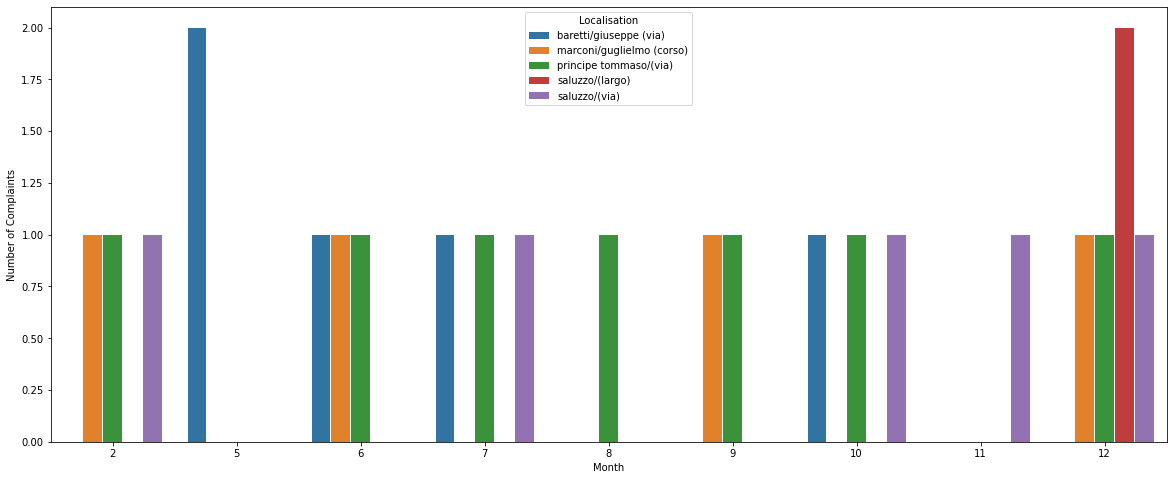

In [13]:
fig, ax = pylab.subplots(figsize=(20, 8))

sns.barplot(data=df_grouped, ax=ax, x="Month", y="Number of Complaints", hue="Localization")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .15)
pylab.legend(loc='upper center', title="Localisation")
pylab.show()

In [14]:
def create_target_complaints(df_filtered_san_salvario, range_days = 2, target_forecast = 1):

    complaint_dates = pd.to_datetime(df_filtered_san_salvario['Date']).unique()

    # Target dates: same day or subtract one day (by default)
    range_deltas = [pd.Timedelta(x + target_forecast, 'd') for x in np.arange(0, range_days)]
    
    target_dates = []
    for x in range_deltas:
        for y in complaint_dates:
            target_dates.append(y - x)
            
    return target_dates, complaint_dates

In [15]:
target_dates, complaint_dates = create_target_complaints(df_filtered_san_salvario)

In [16]:
# Queixa no dia 24
# Houve barulho no 24 ou 23 
# Queremos prever no 23 ou 22

In [17]:
sorted(target_dates)[0:2], sorted(complaint_dates)[0]

([Timestamp('2016-02-22 00:00:00'), Timestamp('2016-02-23 00:00:00')],
 numpy.datetime64('2016-02-24T00:00:00.000000000'))

In [18]:
data['Timestamp_trunc'] = data['Timestamp'].truncate()

In [19]:
data['complaint_followed'] = np.where(data['Timestamp_trunc'].isin(target_dates), 1, 0)

In [20]:
# Filtrar dataset de treino para as datas

# Exploratory Data Analysis

## Sensor Location

TODO: Description here about the sensors' proximity

In [21]:
import folium

m = folium.Map(location=[45.0530, 7.6798], zoom_start=15)

for indice, row in sensor_list.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['address'],
        icon=folium.Icon(color="red", icon='volume-up', prefix='fa')
        ).add_to(m)

m

## Sazonality and regular behavior studies

In [22]:
import holidays
import numpy as np

it_holidays = holidays.CountryHoliday('Italy')

# We created a function to get some interesting date features, based on Pandas DataSeries predefined functions
def get_date_features(df_resampled, date_col, suffix, holidays_list):
    """
    Function for getting date features from a datetime column. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    # df_resampled[f'year_{suffix}'] = df_resampled[date_col].dt.year
    df_resampled[f'quarter_{suffix}'] = df_resampled[date_col].dt.quarter
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in holidays_list)
    # df_resampled[f'is_year_end_{suffix}'] = df_resampled[date_col].dt.is_year_end
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

data = get_date_features(data, date_col='Timestamp', suffix='now', holidays_list=it_holidays)

In [23]:
def noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity'):
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) & (data[value_col] > data['day_max_db'])
    mask_night = (data[date_col] > 22) | (data[date_col] < 6) & (data[value_col] > data['night_max_db'])
    mask = mask_day | mask_night

    data[f'noise_exceeds_threshold_{suffix}'] = np.where(mask, 1, 0)
    
    return data

In [24]:
data = noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity')

In [25]:
def current_db(data, date_col='hour_now'):
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) 
    mask_night = (data[date_col] > 22) | (data[date_col] < 6) 
    mask = mask_day | mask_night

    data[f'current_max_db_value'] = np.where(mask==mask_day, data[f'day_max_db'], data[f'night_max_db'])
    
    return data

In [26]:
data = current_db(data, date_col='hour_now')
data['relative_diff'] = (data.Intensity - data.current_max_db_value	) / data.Intensity 

In [27]:
def dbmean(levels, axis=None):
    """
    Energetic average of levels.
    :param levels: Sequence of levels.
    :param axis: Axis over which to perform the operation.
    .. math:: L_{mean} = 10 \\log_{10}{\\frac{1}{n}\\sum_{i=0}^n{10^{L/10}}}
    """
    # levels = np.asanyarray(levels)
    return 10.0 * np.log10((10.0**(levels / 10.0)).mean(axis=axis))

In [28]:
avg_intensity_per_hour = data[data.Sensor_ID == 'C1'].groupby('hour_now')['Intensity'].apply(dbmean)

Text(0.5, 0, 'Hour of day (h)')

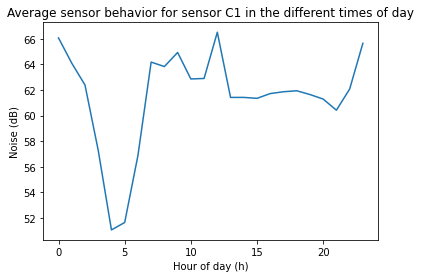

In [29]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(avg_intensity_per_hour)), avg_intensity_per_hour.values)
plt.title('Average sensor behavior for sensor C1 in the different times of day')
plt.ylabel('Noise (dB)')
plt.xlabel('Hour of day (h)')

In [30]:
# We create a function to create our targets
# As you can see, we created our target (label) based on a date offset (i.e., our label will be the intensity of the next day at the same time)
def create_target(df_resampled, date_col = 'Timestamp', target_col = 'Intensity', entity_id='Sensor_ID', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled[f'date_col_{target_col}'] = df_resampled[date_col] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]].merge(
        df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]], 
        left_on = [entity_id, f'date_col_{target_col}'], 
        right_on=[entity_id, date_col], 
        how='left'
    )

    tmp = tmp[[entity_id, f'{date_col}_x', f'{target_col}_y']]
    tmp.columns = [entity_id, date_col, f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=[entity_id, date_col])
    
    return df_resampled

In [31]:
data = create_target(data, target_col='Intensity', date_offset=24)

In [32]:
data = get_date_features(data, date_col='date_col_Intensity', suffix='target', holidays_list=it_holidays)


In [33]:
data = noise_threshold(data, date_col='hour_target', suffix='target', value_col='target_Intensity_24h')

In [34]:
# Avg noise intensity next 3 hours

#indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
#data['average_intensity_next_3h'] = data.groupby(['Sensor_ID'])['Intensity'].rolling(window=indexer, min_periods=1).agg(dbmean).reset_index()['Intensity']
# data = noise_threshold(data, date_col='hour_target', suffix='target_2')

## Train first model

In [35]:
# We create a list of columns that we do not need to train our model
COLS_TO_REMOVE = [
    'Timestamp',
    'Sensor_ID',
    'address',
    'Lat',
    'Long',
    'area_type',
    'target_Intensity_24h',
    'date_col_Intensity',
    'noise_exceeds_threshold_target',
    'Timestamp_trunc',
    'complaint_followed'
    #'average_intensity_next_3h',
    #'noise_exceeds_threshold_target_2'
]

# Based on the previous list, we create a new list with the features that we actually need!
COLS_TO_KEEP = [x for x in data.columns if x not in COLS_TO_REMOVE]

In [36]:
COLS_TO_KEEP

['Intensity',
 'day_max_db',
 'night_max_db',
 'day_now',
 'hour_now',
 'month_now',
 'dayofweek_now',
 'quarter_now',
 'is_holiday_now',
 'is_weekend_now',
 'noise_exceeds_threshold_now',
 'current_max_db_value',
 'relative_diff',
 'day_target',
 'hour_target',
 'month_target',
 'dayofweek_target',
 'quarter_target',
 'is_holiday_target',
 'is_weekend_target']

In [37]:
COLS_TO_REMOVE

['Timestamp',
 'Sensor_ID',
 'address',
 'Lat',
 'Long',
 'area_type',
 'target_Intensity_24h',
 'date_col_Intensity',
 'noise_exceeds_threshold_target',
 'Timestamp_trunc',
 'complaint_followed']

In [38]:
data = data.sort_values(by=['Timestamp', 'Sensor_ID']).reset_index(drop=True)

In [39]:
target_1 = 'target_Intensity_24h'

from xgboost import XGBClassifier

# Train model
# Please note that we use 80% of the data set as our train set!
X_train = data[0:int(0.7*len(data))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train[target_1].isna()]

# We use the remaining 20% as test set
X_test_noise = data[int(0.7*len(data)):]

# We remove the NaNs (labels that are NaNs)
X_test_noise = X_test_noise[~X_test_noise[target_1].isna()]

# Our labels column
y_train = X_train['noise_exceeds_threshold_target']

# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb_noise = XGBClassifier(n_estimators=100)

# We train our model
xgb_noise.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

y_pred = xgb_noise.predict_proba(X_test_noise[COLS_TO_KEEP].fillna(9999).astype(float))
X_test_noise['pred_score_noise'] = y_pred[:, 1]

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:26] WARNING: xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
X_train.Timestamp.max(), X_test_noise.Timestamp.min()

(Timestamp('2018-12-04 07:00:00'), Timestamp('2018-12-04 07:00:00'))

In [41]:
# X_test[(X_test.noise_exceeds_threshold_target == 1)][['Timestamp', 'Sensor_ID', 'Intensity', 'target_Intensity_24h']]

In [42]:
from sklearn.metrics import roc_auc_score

print("ROC AUC", roc_auc_score(X_test_noise['noise_exceeds_threshold_target'], y_pred[:, 1]))

ROC AUC 0.9260860331856475


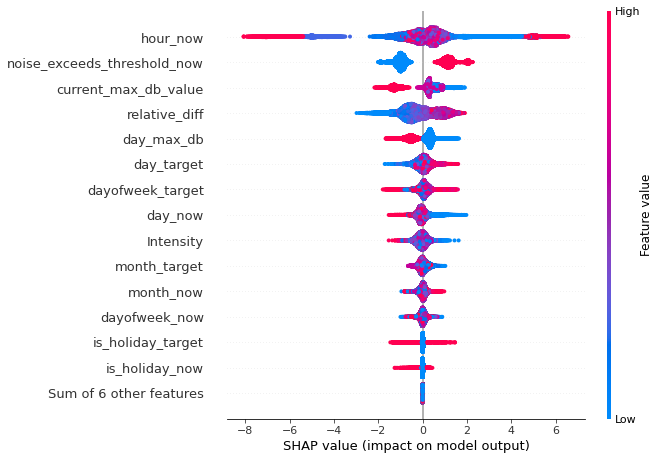

In [43]:
import shap
# Shap explanation

# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_noise)
shap_values_noise = explainer(X_test_noise[COLS_TO_KEEP].fillna(9999).astype(float))

# Let's get a nice plot with the shap values so you can have an intuition on the rationale behind the model learned by the XGBoost Regressor
shap.plots.beeswarm(shap_values_noise, max_display=15)

In [70]:
target_1 = 'complaint_followed'

from xgboost import XGBClassifier

# Train model
# Please note that we use 80% of the data set as our train set!
X_train = data[0:int(0.7*len(data))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train[target_1].isna()]

# We use the remaining 20% as test set
X_test_comp = data[int(0.7*len(data)):]

# We remove the NaNs (labels that are NaNs)
X_test_comp = X_test_comp[~X_test_comp[target_1].isna()]

# Our labels column
y_train = X_train[target_1]

# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb_complaint = XGBClassifier(n_estimators=100)

# We train our model
xgb_complaint.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

y_pred = xgb_complaint.predict_proba(X_test_comp[COLS_TO_KEEP].fillna(9999).astype(float))
X_test_comp['pred_score_complaint'] = y_pred[:, 1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:09:43] WARNING: xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
print("ROC AUC", roc_auc_score(X_test_comp['complaint_followed'], y_pred[:, 1]))

ROC AUC 0.965408740110147


In [72]:
y_pred[:, 1].mean()

0.0008426363

In [75]:
import shap
# Shap explanation

# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_complaint)
shap_complaint_values = explainer(X_test_comp[COLS_TO_KEEP].fillna(9999).astype(float))

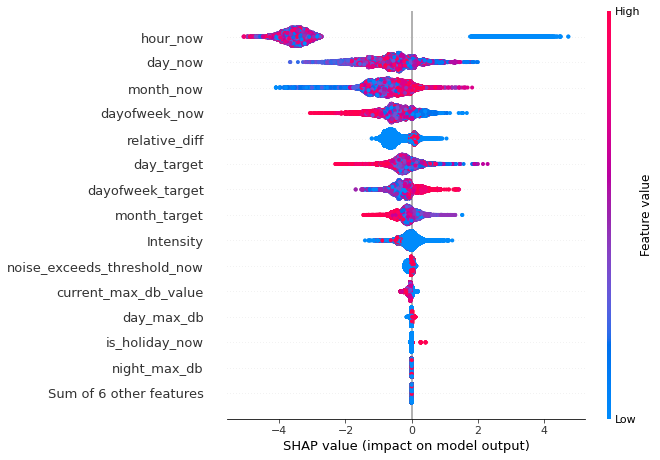

In [76]:
shap.plots.beeswarm(shap_complaint_values, max_display=15)

## Decision Process

In [63]:
# Create a dict mapping the features to its name written in a less technical way
mapping_dict = {
    'Intensity':'Measured intensity in dB, at current date:',
    'day_max_db':'Maximum value of noise in dB, during day:',
    'night_max_db':'Maximum value of noise in dB, during day:',
    'day_now':'Current day:',
    'hour_now':'Current hour:',
    'month_now':'Current month:',
    'dayofweek_now':'Current day of the week:',
    'quarter_now':'Current quarter of the year:',
    'is_holiday_now':'Is this a holiday?',
    'is_weekend_now':'Is this weekend?',
    'noise_exceeds_threshold_now':'Does the current noise exceed the threshold value at this moment?',
    'current_max_db_value':'Maximum value of noise in dB, at this moment:',
    'relative_diff':'Difference between the current maximum of noise and the measured intensity:',
    'day_target':'The target day of this prediction:',
    'hour_target':'The target hour of this prediction:',
    'month_target':'The target month of this prediction:',
    'dayofweek_target':'The target day of the week of this prediction',
    'quarter_target':'The target quarter of year of this prediction',
    'is_holiday_target':'Is the target day of this prediction, a holiday?',
    'is_weekend_target':'Is the target day of this prediction, a weekend?',
}

In [64]:
def generate_explanation(figure_data, mapping_dict):
    
    # Get features names
    feature_names = figure_data['featureNames']
    # print(feature_names)
    
    # Get feature values
    feature_values = list()
    
    # Go through the dictionary
    explanation = str()
    for key, value in figure_data['features'].items():
        feature_text = mapping_dict.get(feature_names[key], "Feature is not available in the mapping dictionary:")
        feature_value = value['value']
        
        explanation += f"{feature_text} {feature_value}; "
    
    
    return explanation

In [51]:
# Initialise JavaScript
shap.initjs()

# Add for loop for each of the sensor.
# For each, plot the figure and add the text
figures = list()

# X_test_noise.shape, shap_values_noise.shape


for index in range(len(X_test_noise)):
    fig = shap.plots.force(shap_values_noise[X_test_noise[COLS_TO_KEEP].reset_index(drop=True).index[index]])
    figures.append(fig)


print(f"There are {len(figures)} figures")

There are 42271 figures


In [65]:
# Let's append figures data in a new list
figures_data = [fig.data for fig in figures]
# figures_data

In [66]:
# An example figure
figures[0]

In [67]:
# Loop through explanations
explanations_noise = list()
for fig_data in figures_data:
    exp = generate_explanation(fig_data, mapping_dict)
    explanations_noise.append(exp)
    
# explanations_complaints
explanations_noise_df = pd.DataFrame(explanations_noise, columns=['Explanation of Noise'])
explanations_noise_df

,Explanation of Noise
0,"Measured intensity in dB, at current date: 62...."
1,"Measured intensity in dB, at current date: 67...."
2,"Measured intensity in dB, at current date: 65...."
3,"Measured intensity in dB, at current date: 61...."
4,"Measured intensity in dB, at current date: 63...."
...,...
42266,"Measured intensity in dB, at current date: 57...."
42267,"Measured intensity in dB, at current date: 60...."
42268,"Measured intensity in dB, at current date: 57...."
42269,"Measured intensity in dB, at current date: 57...."


In [68]:
# Example explanation value for the Noise
explanations_noise_df.loc[0]['Explanation of Noise']

'Measured intensity in dB, at current date: 62.4;Maximum value of noise in dB, during day: 60.0;Current day: 4.0;Current hour: 7.0;Current month: 12.0;Current day of the week: 1.0;Is this a holiday? 0.0;Does the current noise exceed the threshold value at this moment? 1.0;Maximum value of noise in dB, at this moment: 60.0;Difference between the current maximum of noise and the measured intensity: 0.03846153846153844;The target day of this prediction: 5.0;The target month of this prediction: 12.0;The target day of the week of this prediction 2.0;Is the target day of this prediction, a holiday? 0.0;'

In [77]:
# Initialise JavaScript
shap.initjs()

# Add for loop for each of the sensor.
# For each, plot the figure and add the text
figures = list()


for index in range(len(X_test_comp)):
    fig = shap.plots.force(shap_complaint_values[X_test_comp[COLS_TO_KEEP].reset_index(drop=True).index[index]])
    figures.append(fig)


print(f"There are {len(figures)} figures")

There are 47124 figures


In [78]:
# Let's append figures data in a new list
figures_data = [fig.data for fig in figures]
# figures_data

In [79]:
# An example figure
figures[0]

In [80]:
# Loop through explanations
explanations_complaints = list()

for fig_data in figures_data:
    exp = generate_explanation(fig_data, mapping_dict)
    explanations_complaints.append(exp)
    
# explanations_complaints
explanations_complaints_df = pd.DataFrame(explanations_complaints, columns=['Explanation of Complaint']).astype(str)
explanations_complaints_df

,Explanation of Complaint
0,"Measured intensity in dB, at current date: 62...."
1,"Measured intensity in dB, at current date: 999..."
2,"Measured intensity in dB, at current date: 67...."
3,"Measured intensity in dB, at current date: 65...."
4,"Measured intensity in dB, at current date: 61...."
...,...
47119,"Measured intensity in dB, at current date: 60...."
47120,"Measured intensity in dB, at current date: 63...."
47121,"Measured intensity in dB, at current date: 65...."
47122,"Measured intensity in dB, at current date: 999..."


In [84]:
# Initialise JavaScript
shap.initjs()

# Add for loop for each of the sensor.
# For each, plot the figure and add the text
figures = list()

for index in range(len(X_test_comp)):
    fig = shap.plots.force(shap_complaint_values[X_test_comp.reset_index(drop=True).index[index]])
    figures.append(fig)

print(f"There are {len(figures)} figures")

There are 47124 figures


In [86]:
# Write pandas DataFrame with
from datetime import timedelta
final_results = X_test_noise.copy()[['Sensor_ID', 'Timestamp']]
final_results['Prediction Hour'] = final_results['Timestamp'] + timedelta(days=1)
final_results['Probability of Noise Above'] = X_test_noise['pred_score_noise']
final_results['Explanation for Noise'] = explanations_noise_df['Explanation of Noise']
final_results['Probability of Complaint'] = X_test_comp['pred_score_complaint']
final_results['Explanation of Complaint'] = explanations_complaints_df['Explanation of Complaint']

final_results


# prediction_hour
# sensor_id
# probability modelo 1
# probability modelo 2
# explanation modelo 1
# explanation modelo 2

,Sensor_ID,Timestamp,Prediction Hour,Probability of Noise Above,Explanation for Noise,Probability of Complaint,Explanation of Complaint
109956,C2,2018-12-04 07:00:00,2018-12-05 07:00:00,0.837129,NaN,2.175960e-06,NaN
109958,C4,2018-12-04 07:00:00,2018-12-05 07:00:00,0.157541,NaN,1.027433e-06,NaN
109959,C5,2018-12-04 07:00:00,2018-12-05 07:00:00,0.891775,NaN,2.943261e-06,NaN
109960,C1,2018-12-04 08:00:00,2018-12-05 08:00:00,0.152281,NaN,1.619539e-06,NaN
109961,C2,2018-12-04 08:00:00,2018-12-05 08:00:00,0.881049,NaN,1.222732e-06,NaN
...,...,...,...,...,...,...,...
156951,C2,2019-12-30 22:00:00,2019-12-31 22:00:00,0.000350,NaN,7.963037e-07,NaN
156952,C3,2019-12-30 22:00:00,2019-12-31 22:00:00,0.000832,NaN,4.880547e-07,NaN
156955,C1,2019-12-30 23:00:00,2019-12-31 23:00:00,0.999755,NaN,2.233733e-06,NaN
156956,C2,2019-12-30 23:00:00,2019-12-31 23:00:00,0.999984,NaN,6.400617e-07,NaN


## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀